## Hypothesis I - Baseline Model

##### Input: Vegetation Indices + Texture Properties + Thermal features

##### Downstream Model: LASSO Model

##### Validation: 5-fold CV


In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import shap

import joblib

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Preprocessing


In [3]:
LATE_BOOT_DATES = ["2021-06-14", "2021-06-23", "2021-06-30", "2021-07-28"]

# load 2021 (training)
dfTrain = pd.read_csv("../../Datasets/2021/Dataset_2021.csv")

# remove missing yield
dfTrain = dfTrain[dfTrain["Yield"].notna()]

# Only keep dates that occur on/before late booting stage
dfTrain["Date"] = pd.to_datetime(dfTrain["Date"]).dt.strftime("%Y-%m-%d")
dfTrain = dfTrain[dfTrain["Date"].isin(LATE_BOOT_DATES)]

# remove vegetation fraction
dfTrain.drop("Vegetation_Fraction", axis=1, inplace=True)

# scale features (using late Boot dates)
scaler = StandardScaler()
dfTrain.iloc[:, 17:] = scaler.fit_transform(dfTrain.iloc[:, 17:])

# widen dataset
dfLongTrain = pd.melt(
    dfTrain.iloc[:, np.r_[0:8, 17 : len(dfTrain.columns)]],
    id_vars=dfTrain.iloc[:, 0:8],
    value_vars=dfTrain.iloc[:, 17:],
)

dfWideTrain = pd.pivot(
    dfLongTrain,
    columns=["Date", "variable"],
    values="value",
    index=[
        "Plot_Number",
        "Rice_Cultivar",
        "Experiment_Name",
        "Bay_Length",
        "Nitrogen_Rate",
        "Replicate",
        "Yield",
    ],
).reset_index()
dfWideTrain.columns = [
    str(s1) + "_" + str(s2) if str(s2) != "" else str(s1)
    for (s1, s2) in dfWideTrain.columns.tolist()
]

### Training


In [4]:
def lassoCV_custom(xTrain, yTrain, nfolds, alpha=1):
    kfold = KFold(n_splits=nfolds, shuffle=True, random_state=100)

    cvResults = []
    for trainIndices, valIndices in kfold.split(xTrain):
        xTrainCV, xValCV = xTrain[trainIndices], xTrain[valIndices]
        yTrainCV, yValCV = yTrain[trainIndices], yTrain[valIndices]

        # fit model
        lassoModel = Lasso(max_iter=10000, alpha=alpha)
        lassoModel.fit(xTrainCV, yTrainCV)
        preds = lassoModel.predict(xValCV)
        cvResults.append(mean_squared_error(yValCV, preds, squared=False))

    return cvResults

In [5]:
xTrain = dfWideTrain.iloc[:, 7:].values
yTrain = dfWideTrain["Yield"]
N_FOLDS = 5

defaultModel = Lasso(max_iter=10000).fit(xTrain, yTrain)

print(f"RMSE 5-fold CV: {np.mean(lassoCV_custom(xTrain, yTrain, N_FOLDS))}")
print(
    f"Training RMSE: {mean_squared_error(yTrain, defaultModel.predict(xTrain), squared=False)}"
)

RMSE 5-fold CV: 2.5673335407415387
Training RMSE: 2.552811046921285


### Tuning Lambda


In [5]:
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=100)
tunedModel = LassoCV(max_iter=10000, cv=cv, n_jobs=-1).fit(xTrain, yTrain)

### Visualize CV


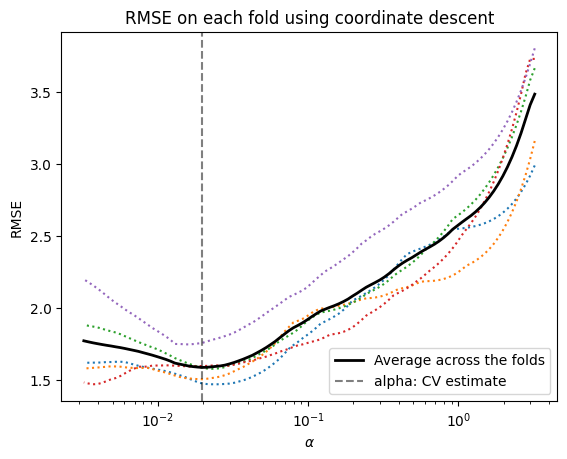

In [6]:
plt.semilogx(tunedModel.alphas_, tunedModel.mse_path_**0.5, linestyle=":")
plt.plot(
    tunedModel.alphas_,
    tunedModel.mse_path_.mean(axis=-1) ** 0.5,
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    tunedModel.alpha_,
    linestyle="--",
    color="black",
    label="alpha: CV estimate",
    alpha=0.5,
)

plt.xlabel(r"$\alpha$")
plt.ylabel("RMSE")
plt.legend()
_ = plt.title(f"RMSE on each fold using coordinate descent")

In [7]:
print(
    f"RMSE 5-fold CV: {np.mean(lassoCV_custom(xTrain, yTrain, N_FOLDS, tunedModel.alpha_))}"
)
print(
    f"Training RMSE: {mean_squared_error(yTrain, tunedModel.predict(xTrain), squared=False)}"
)

RMSE 5-fold CV: 1.5842346974200965
Training RMSE: 1.2962211565258073


### Interpret Model


In [8]:
explainer = shap.Explainer(lambda x: tunedModel.predict(x), xTrain)
shapValues = explainer(xTrain)

Permutation explainer: 225it [00:23,  6.22it/s]                         


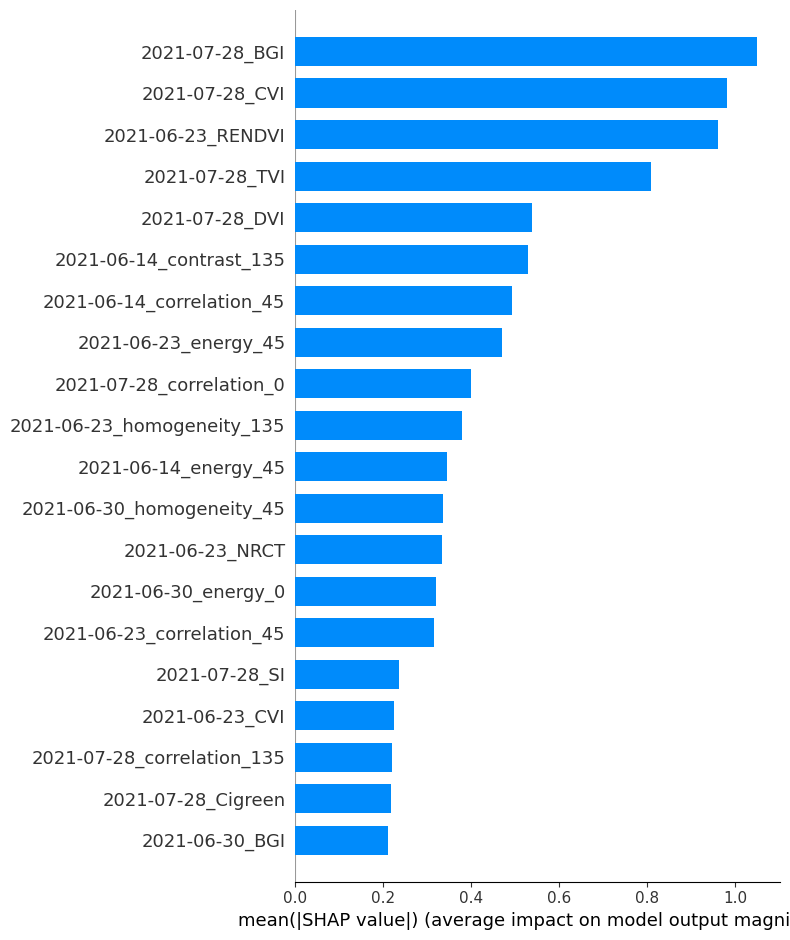

In [9]:
shap.summary_plot(shapValues, plot_type="bar", feature_names=dfWideTrain.columns[7:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


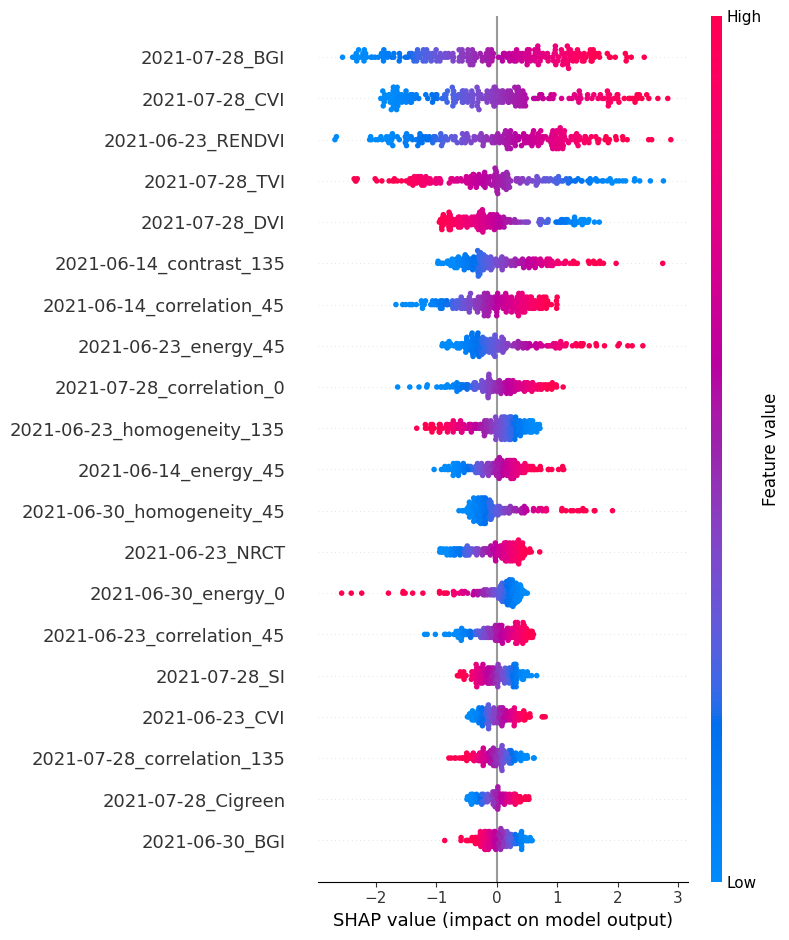

In [10]:
shap.summary_plot(shapValues, plot_type="dot", feature_names=dfWideTrain.columns[7:])

### Export Model


In [ ]:
# save tuned model
joblib.dump(tunedModel, "Saved_Models/Baseline_LASSO")